In [6]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,r2_score

### DataSet

In [7]:
set_config(transform_output = "pandas")

In [8]:
# load the dataset
data = fetch_california_housing(as_frame=True)

In [9]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [10]:
X,y = data.data, data.target

In [11]:
features_names = data.feature_names

features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [12]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [13]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [14]:
X.shape

(20640, 8)

In [16]:
# split the dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("Training set shape:",X_train.shape)
print("Testing set shape:",X_test.shape)

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


In [20]:
# model
xgb_model = XGBRegressor(objective='reg:squarederror',random_state=42,n_jobs=-1,learning_rate=0.2,n_estimators=200,reg_lambda=50,       max_depth=7)

In [21]:
# fit the training data
xgb_model.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [23]:
# calculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

#calculate the evaluation metrics
rmse_train = root_mean_squared_error(y_train,y_pred_train)
rmse_test = root_mean_squared_error(y_test,y_pred_test)

r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2740, R2: 0.9438
Test RMSE: 0.4460, R2: 0.8482


### HP Tuning

In [27]:
# tune the model

def objective(trial):

    params = {
        "learning_rate":trial.suggest_float('learning_rate',0.01,0.3),
        'n_estimators': trial.suggest_int('n_estimators',50,500),
        'max_depth': trial.suggest_int('max_depth',3,10),
        'reg_lambda': trial.suggest_float('reg_lambda',1,100),
        'subsample': trial.suggest_float('subsample',0.7,1.0),
        'n_jobs':-1,
        'objective': 'reg:squarederror',
        'random_state':42
    }

    # set the model
    model = XGBRegressor()

    model.set_params(**params)

    #fit the model
    model.fit(X_train,y_train)

    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    
    return r2

In [28]:
# create the study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective,n_trials=50,show_progress_bar=True,n_jobs=-1)

[I 2026-01-26 21:18:11,254] A new study created in memory with name: no-name-d9a36561-9d6b-4a6b-bd88-1e2867ed3a34
Best trial: 5. Best value: 0.792401:   2%|▏         | 1/50 [00:00<00:42,  1.16it/s]

[I 2026-01-26 21:18:12,113] Trial 5 finished with value: 0.7924010454200636 and parameters: {'learning_rate': 0.11360609387859745, 'n_estimators': 78, 'max_depth': 4, 'reg_lambda': 62.1583620852736, 'subsample': 0.9995065356119222}. Best is trial 5 with value: 0.7924010454200636.


Best trial: 6. Best value: 0.815072:   4%|▍         | 2/50 [00:01<00:31,  1.51it/s]

[I 2026-01-26 21:18:12,636] Trial 6 finished with value: 0.8150722165374409 and parameters: {'learning_rate': 0.11042815266651561, 'n_estimators': 83, 'max_depth': 6, 'reg_lambda': 87.93948836933862, 'subsample': 0.7322133739452434}. Best is trial 6 with value: 0.8150722165374409.


Best trial: 1. Best value: 0.826638:   6%|▌         | 3/50 [00:01<00:20,  2.27it/s]

[I 2026-01-26 21:18:12,811] Trial 1 finished with value: 0.8266379259474486 and parameters: {'learning_rate': 0.13401181713124038, 'n_estimators': 116, 'max_depth': 5, 'reg_lambda': 32.5565079163843, 'subsample': 0.9154940474941846}. Best is trial 1 with value: 0.8266379259474486.


Best trial: 2. Best value: 0.8276:   8%|▊         | 4/50 [00:02<00:29,  1.56it/s]  

[I 2026-01-26 21:18:13,762] Trial 2 finished with value: 0.8275996931555957 and parameters: {'learning_rate': 0.281204354877112, 'n_estimators': 259, 'max_depth': 3, 'reg_lambda': 80.54484591783267, 'subsample': 0.8389612473219736}. Best is trial 2 with value: 0.8275996931555957.


Best trial: 0. Best value: 0.842112:  10%|█         | 5/50 [00:03<00:28,  1.57it/s]

[I 2026-01-26 21:18:14,388] Trial 0 finished with value: 0.8421116871018355 and parameters: {'learning_rate': 0.18215012470182962, 'n_estimators': 220, 'max_depth': 5, 'reg_lambda': 47.44178495824333, 'subsample': 0.8534458315532629}. Best is trial 0 with value: 0.8421116871018355.


Best trial: 4. Best value: 0.847924:  12%|█▏        | 6/50 [00:03<00:29,  1.49it/s]

[I 2026-01-26 21:18:15,108] Trial 4 finished with value: 0.8479241186351824 and parameters: {'learning_rate': 0.2776171239525353, 'n_estimators': 160, 'max_depth': 8, 'reg_lambda': 77.5016760593002, 'subsample': 0.8731334297015635}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 4. Best value: 0.847924:  14%|█▍        | 7/50 [00:04<00:22,  1.92it/s]

[I 2026-01-26 21:18:15,336] Trial 11 finished with value: 0.837248335204962 and parameters: {'learning_rate': 0.1886826894747961, 'n_estimators': 81, 'max_depth': 7, 'reg_lambda': 29.337546079556216, 'subsample': 0.8281232218885515}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 4. Best value: 0.847924:  16%|█▌        | 8/50 [00:04<00:18,  2.25it/s]

[I 2026-01-26 21:18:15,622] Trial 10 finished with value: 0.8405628442874649 and parameters: {'learning_rate': 0.28371204787874743, 'n_estimators': 117, 'max_depth': 8, 'reg_lambda': 34.82876891393376, 'subsample': 0.7048769197877935}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 4. Best value: 0.847924:  18%|█▊        | 9/50 [00:04<00:18,  2.24it/s]

[I 2026-01-26 21:18:16,072] Trial 7 finished with value: 0.8446326999451836 and parameters: {'learning_rate': 0.1766676499455293, 'n_estimators': 413, 'max_depth': 4, 'reg_lambda': 31.244345438245656, 'subsample': 0.7482390662617054}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 4. Best value: 0.847924:  20%|██        | 10/50 [00:05<00:15,  2.51it/s]

[I 2026-01-26 21:18:16,361] Trial 13 finished with value: 0.8241007599403405 and parameters: {'learning_rate': 0.23727014608304742, 'n_estimators': 105, 'max_depth': 4, 'reg_lambda': 49.735061466148665, 'subsample': 0.759998514820193}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 4. Best value: 0.847924:  22%|██▏       | 11/50 [00:05<00:18,  2.12it/s]

[I 2026-01-26 21:18:17,002] Trial 9 finished with value: 0.8463983283336454 and parameters: {'learning_rate': 0.24052916042874448, 'n_estimators': 304, 'max_depth': 5, 'reg_lambda': 52.79324198373111, 'subsample': 0.7051931146761892}. Best is trial 4 with value: 0.8479241186351824.


Best trial: 12. Best value: 0.850016:  24%|██▍       | 12/50 [00:08<00:44,  1.17s/it]

[I 2026-01-26 21:18:19,776] Trial 12 finished with value: 0.8500155945736255 and parameters: {'learning_rate': 0.2445867090996116, 'n_estimators': 290, 'max_depth': 6, 'reg_lambda': 37.61586757361669, 'subsample': 0.81792568799338}. Best is trial 12 with value: 0.8500155945736255.


Best trial: 12. Best value: 0.850016:  26%|██▌       | 13/50 [00:08<00:33,  1.10it/s]

[I 2026-01-26 21:18:20,080] Trial 16 finished with value: 0.8471621620617911 and parameters: {'learning_rate': 0.15860793270640502, 'n_estimators': 125, 'max_depth': 9, 'reg_lambda': 94.96082478963814, 'subsample': 0.8517954997840902}. Best is trial 12 with value: 0.8500155945736255.


Best trial: 12. Best value: 0.850016:  28%|██▊       | 14/50 [00:10<00:40,  1.11s/it]

[I 2026-01-26 21:18:21,669] Trial 14 finished with value: 0.8291809091080633 and parameters: {'learning_rate': 0.050604751163150295, 'n_estimators': 363, 'max_depth': 5, 'reg_lambda': 96.48447493653514, 'subsample': 0.9383435211164888}. Best is trial 12 with value: 0.8500155945736255.


Best trial: 15. Best value: 0.855478:  30%|███       | 15/50 [00:14<01:13,  2.10s/it]

[I 2026-01-26 21:18:26,060] Trial 15 finished with value: 0.8554777908297622 and parameters: {'learning_rate': 0.2555259906411019, 'n_estimators': 444, 'max_depth': 6, 'reg_lambda': 97.57979750801034, 'subsample': 0.9268001988452623}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  32%|███▏      | 16/50 [00:16<01:07,  1.99s/it]

[I 2026-01-26 21:18:27,804] Trial 3 finished with value: 0.8357915255279872 and parameters: {'learning_rate': 0.2596202800574021, 'n_estimators': 467, 'max_depth': 9, 'reg_lambda': 13.96408217222935, 'subsample': 0.8987306874652425}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  34%|███▍      | 17/50 [00:18<01:00,  1.84s/it]

[I 2026-01-26 21:18:29,271] Trial 8 finished with value: 0.8451876825834803 and parameters: {'learning_rate': 0.1875086226346777, 'n_estimators': 426, 'max_depth': 10, 'reg_lambda': 30.01850798330268, 'subsample': 0.9445991516640756}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  36%|███▌      | 18/50 [00:22<01:19,  2.49s/it]

[I 2026-01-26 21:18:33,294] Trial 17 finished with value: 0.8385893347690363 and parameters: {'learning_rate': 0.020176044655296377, 'n_estimators': 372, 'max_depth': 10, 'reg_lambda': 8.22057009981728, 'subsample': 0.9371165083329196}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:33,324] Trial 18 finished with value: 0.8371300649566937 and parameters: {'learning_rate': 0.01884112726911455, 'n_estimators': 366, 'max_depth': 10, 'reg_lambda': 9.18949221051512, 'subsample': 0.9167261201796}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  40%|████      | 20/50 [00:22<00:46,  1.54s/it]

[I 2026-01-26 21:18:34,167] Trial 19 finished with value: 0.8463409835512665 and parameters: {'learning_rate': 0.03500506298719626, 'n_estimators': 374, 'max_depth': 9, 'reg_lambda': 14.136636906684593, 'subsample': 0.9039669628249264}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:34,197] Trial 20 finished with value: 0.8455488889387166 and parameters: {'learning_rate': 0.2346972982751012, 'n_estimators': 361, 'max_depth': 9, 'reg_lambda': 75.80535682174954, 'subsample': 0.9064170215102431}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  44%|████▍     | 22/50 [00:25<00:41,  1.49s/it]

[I 2026-01-26 21:18:36,969] Trial 24 finished with value: 0.8444101166078465 and parameters: {'learning_rate': 0.21786546364440473, 'n_estimators': 344, 'max_depth': 7, 'reg_lambda': 8.759180548125123, 'subsample': 0.812578108258163}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  48%|████▊     | 24/50 [00:26<00:27,  1.04s/it]

[I 2026-01-26 21:18:37,756] Trial 22 finished with value: 0.8366721825624133 and parameters: {'learning_rate': 0.23064903791777516, 'n_estimators': 481, 'max_depth': 7, 'reg_lambda': 7.8747167060715455, 'subsample': 0.7959685872005479}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:37,879] Trial 28 finished with value: 0.843132293690896 and parameters: {'learning_rate': 0.2954986211565156, 'n_estimators': 187, 'max_depth': 7, 'reg_lambda': 71.21396746678987, 'subsample': 0.8006067563891176}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  50%|█████     | 25/50 [00:27<00:25,  1.02s/it]

[I 2026-01-26 21:18:38,842] Trial 23 finished with value: 0.8426520603500668 and parameters: {'learning_rate': 0.20637533336140998, 'n_estimators': 492, 'max_depth': 7, 'reg_lambda': 3.8332664156956042, 'subsample': 0.7881686112825379}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  52%|█████▏    | 26/50 [00:28<00:22,  1.06it/s]

[I 2026-01-26 21:18:39,582] Trial 29 finished with value: 0.8459386470435993 and parameters: {'learning_rate': 0.29822122891462366, 'n_estimators': 179, 'max_depth': 6, 'reg_lambda': 71.70036669411553, 'subsample': 0.7996852223255083}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  54%|█████▍    | 27/50 [00:29<00:20,  1.11it/s]

[I 2026-01-26 21:18:40,377] Trial 30 finished with value: 0.8487546675576769 and parameters: {'learning_rate': 0.2909893107198073, 'n_estimators': 182, 'max_depth': 6, 'reg_lambda': 70.4673375088744, 'subsample': 0.8747600486133806}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:40,463] Trial 31 finished with value: 0.8484035810244508 and parameters: {'learning_rate': 0.26872193879423256, 'n_estimators': 180, 'max_depth': 6, 'reg_lambda': 85.91685301211598, 'subsample': 0.8730010078386916}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  58%|█████▊    | 29/50 [00:30<00:14,  1.44it/s]

[I 2026-01-26 21:18:41,226] Trial 32 finished with value: 0.8471181260233713 and parameters: {'learning_rate': 0.263232050942068, 'n_estimators': 164, 'max_depth': 6, 'reg_lambda': 87.77557648190245, 'subsample': 0.8751867454863675}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:41,293] Trial 21 finished with value: 0.8328630135916001 and parameters: {'learning_rate': 0.23422163474913774, 'n_estimators': 499, 'max_depth': 10, 'reg_lambda': 4.582576380442525, 'subsample': 0.795646132420171}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  64%|██████▍   | 32/50 [00:31<00:09,  1.89it/s]

[I 2026-01-26 21:18:42,326] Trial 26 finished with value: 0.853148636604933 and parameters: {'learning_rate': 0.21936757426974773, 'n_estimators': 500, 'max_depth': 7, 'reg_lambda': 67.58104910320526, 'subsample': 0.9919927766117912}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:42,462] Trial 25 finished with value: 0.8452551138861498 and parameters: {'learning_rate': 0.2235006855562063, 'n_estimators': 494, 'max_depth': 7, 'reg_lambda': 67.8243861785827, 'subsample': 0.7813431891456103}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  66%|██████▌   | 33/50 [00:31<00:08,  2.04it/s]

[I 2026-01-26 21:18:42,828] Trial 27 finished with value: 0.8469801711868304 and parameters: {'learning_rate': 0.22130292537759616, 'n_estimators': 489, 'max_depth': 7, 'reg_lambda': 61.70726749937393, 'subsample': 0.798222789439328}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  70%|███████   | 35/50 [00:32<00:07,  1.92it/s]

[I 2026-01-26 21:18:43,945] Trial 35 finished with value: 0.8492687687777607 and parameters: {'learning_rate': 0.2522951071340521, 'n_estimators': 255, 'max_depth': 6, 'reg_lambda': 59.836972638612565, 'subsample': 0.9712009259783008}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:44,108] Trial 34 finished with value: 0.8506220936224514 and parameters: {'learning_rate': 0.25977698087286627, 'n_estimators': 273, 'max_depth': 6, 'reg_lambda': 60.24002271796365, 'subsample': 0.8767231963307976}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  72%|███████▏  | 36/50 [00:33<00:06,  2.19it/s]

[I 2026-01-26 21:18:44,395] Trial 36 finished with value: 0.8503950008899885 and parameters: {'learning_rate': 0.2546712557690163, 'n_estimators': 229, 'max_depth': 6, 'reg_lambda': 60.00463829848838, 'subsample': 0.969808855738723}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  74%|███████▍  | 37/50 [00:34<00:07,  1.71it/s]

[I 2026-01-26 21:18:45,312] Trial 33 finished with value: 0.8498822876679287 and parameters: {'learning_rate': 0.26067528295835557, 'n_estimators': 294, 'max_depth': 8, 'reg_lambda': 86.65356430002163, 'subsample': 0.8748415405672878}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  80%|████████  | 40/50 [00:34<00:03,  2.88it/s]

[I 2026-01-26 21:18:45,888] Trial 39 finished with value: 0.8509682215351304 and parameters: {'learning_rate': 0.2560799383396468, 'n_estimators': 242, 'max_depth': 6, 'reg_lambda': 60.96837695340217, 'subsample': 0.9853532467334563}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:45,895] Trial 37 finished with value: 0.8481190737486176 and parameters: {'learning_rate': 0.2568103093774623, 'n_estimators': 235, 'max_depth': 8, 'reg_lambda': 59.26192092106819, 'subsample': 0.9766614731206213}. Best is trial 15 with value: 0.8554777908297622.
[I 2026-01-26 21:18:46,007] Trial 40 finished with value: 0.8482390918381418 and parameters: {'learning_rate': 0.2524933099366634, 'n_estimators': 228, 'max_depth': 6, 'reg_lambda': 42.82914201076965, 'subsample': 0.9894239061605559}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  82%|████████▏ | 41/50 [00:35<00:04,  1.91it/s]

[I 2026-01-26 21:18:47,076] Trial 38 finished with value: 0.8482618191779359 and parameters: {'learning_rate': 0.25260753910309763, 'n_estimators': 246, 'max_depth': 8, 'reg_lambda': 58.37575602862072, 'subsample': 0.9801704482341794}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  84%|████████▍ | 42/50 [00:36<00:04,  1.82it/s]

[I 2026-01-26 21:18:47,703] Trial 44 finished with value: 0.8501863212110704 and parameters: {'learning_rate': 0.2762843274104489, 'n_estimators': 230, 'max_depth': 5, 'reg_lambda': 44.77156508255053, 'subsample': 0.9823353430867683}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  86%|████████▌ | 43/50 [00:37<00:04,  1.59it/s]

[I 2026-01-26 21:18:48,553] Trial 41 finished with value: 0.8472207419955403 and parameters: {'learning_rate': 0.25172842592703815, 'n_estimators': 247, 'max_depth': 8, 'reg_lambda': 56.38140960284964, 'subsample': 0.984734734612313}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 15. Best value: 0.855478:  88%|████████▊ | 44/50 [00:37<00:03,  1.76it/s]

[I 2026-01-26 21:18:48,953] Trial 43 finished with value: 0.8491971671860765 and parameters: {'learning_rate': 0.20477818297743747, 'n_estimators': 240, 'max_depth': 8, 'reg_lambda': 42.65128017351172, 'subsample': 0.9936139497081047}. Best is trial 15 with value: 0.8554777908297622.


Best trial: 47. Best value: 0.855556:  92%|█████████▏| 46/50 [00:39<00:02,  1.69it/s]

[I 2026-01-26 21:18:50,235] Trial 47 finished with value: 0.8555564840910543 and parameters: {'learning_rate': 0.19913000868712805, 'n_estimators': 444, 'max_depth': 5, 'reg_lambda': 81.4164048372101, 'subsample': 0.9534295904552785}. Best is trial 47 with value: 0.8555564840910543.
[I 2026-01-26 21:18:50,387] Trial 45 finished with value: 0.85264910451932 and parameters: {'learning_rate': 0.20708820144284185, 'n_estimators': 455, 'max_depth': 5, 'reg_lambda': 45.355835970170965, 'subsample': 0.9585993074226655}. Best is trial 47 with value: 0.8555564840910543.
[I 2026-01-26 21:18:50,395] Trial 46 finished with value: 0.8512146249334549 and parameters: {'learning_rate': 0.20347752595154403, 'n_estimators': 455, 'max_depth': 5, 'reg_lambda': 41.21787456930365, 'subsample': 0.9971641366738455}. Best is trial 47 with value: 0.8555564840910543.


Best trial: 47. Best value: 0.855556:  96%|█████████▌| 48/50 [00:39<00:00,  2.30it/s]

[I 2026-01-26 21:18:50,876] Trial 48 finished with value: 0.8542324281433257 and parameters: {'learning_rate': 0.19990773285322844, 'n_estimators': 446, 'max_depth': 5, 'reg_lambda': 53.7158855963388, 'subsample': 0.9575970912772352}. Best is trial 47 with value: 0.8555564840910543.


Best trial: 47. Best value: 0.855556: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

[I 2026-01-26 21:18:51,087] Trial 49 finished with value: 0.8536271862125901 and parameters: {'learning_rate': 0.1994446030844575, 'n_estimators': 444, 'max_depth': 5, 'reg_lambda': 65.84526871865306, 'subsample': 0.956671441032819}. Best is trial 47 with value: 0.8555564840910543.
[I 2026-01-26 21:18:51,186] Trial 42 finished with value: 0.8505885652889782 and parameters: {'learning_rate': 0.20547547910696617, 'n_estimators': 446, 'max_depth': 8, 'reg_lambda': 39.84592361032817, 'subsample': 0.9862673803420663}. Best is trial 47 with value: 0.8555564840910543.


In [29]:
# get the best parameters
study.best_params

{'learning_rate': 0.19913000868712805,
 'n_estimators': 444,
 'max_depth': 5,
 'reg_lambda': 81.4164048372101,
 'subsample': 0.9534295904552785}

In [30]:
# best value
study.best_value

0.8555564840910543

In [31]:
best_model  = XGBRegressor(**study.best_params)

best_model.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [32]:
# calculate the predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

#calculate the evaluation metrics
rmse_train = root_mean_squared_error(y_train,y_pred_train)
rmse_test = root_mean_squared_error(y_test,y_pred_test)

r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.3074, R2: 0.9293
Test RMSE: 0.4373, R2: 0.8541


## SHAP

In [33]:
best_model

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [34]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,data=X_train)

In [35]:
# expected value
explainer.expected_value

np.float64(2.0112692650715953)

In [36]:
# calculate the SHAP values
shap_values = explainer(X_test)

 99%|===================| 4074/4128 [00:43<00:00]        

In [38]:
shap_values.shape

(4128, 8)

In [37]:
len(features_names)

8

In [40]:
features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [41]:
shap_values[0:5]

.values =
array([[-0.31833549, -0.00469924, -0.15281433,  0.00805143, -0.01538309,
        -0.19514575, -0.75844296, -0.05605131],
       [-0.29321066,  0.0232391 , -0.1140775 ,  0.0586454 ,  0.01743547,
        -0.02436179, -0.75127974,  0.15667031],
       [ 0.11635779,  0.35600156, -0.09908903,  0.05354027, -0.03544783,
         0.78496718, -0.11293537,  2.01414709],
       [ 0.39412655,  0.02795596,  0.17218658, -0.01938276, -0.00255484,
        -0.30605598,  0.18206652, -0.00524348],
       [-0.03866438, -0.01385711, -0.02960153,  0.02340461, -0.01807932,
         0.00431246, -0.52786601,  1.03182169]])

.base_values =
array([2.01126927, 2.01126927, 2.01126927, 2.01126927, 2.01126927])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02],
       [ 2.53130000e+00,  3.00000000e+01,  5.03938356e+00,
         1.19349315e+00,  1.56500000e+03,  2.67979452e+00,
         3.5

## Global Plots

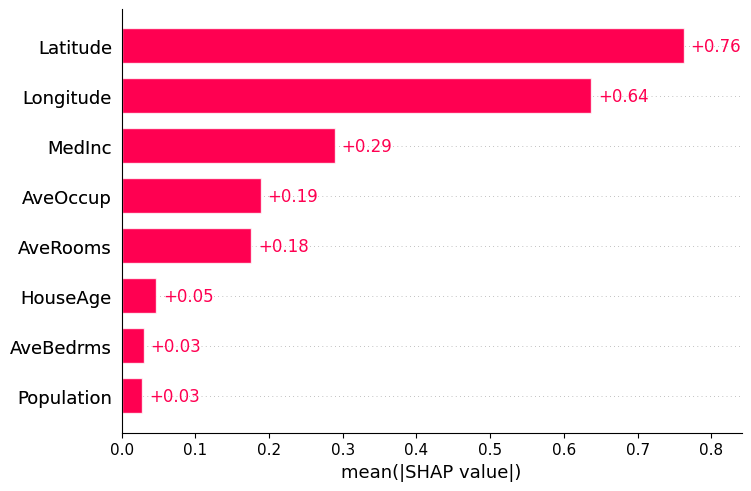

In [42]:
# bar plot to plot features importance

shap.plots.bar(shap_values)

In [46]:
shap_values.abs.mean(axis=0)

.values =
array([0.28891626, 0.04686173, 0.17578302, 0.02992539, 0.02831241,
       0.18886437, 0.76290372, 0.63713554])

.base_values =
np.float64(2.011269265071596)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])